# PIP INSTALL REQUIRED LIBRARIES

In [1]:
# TPU pytorch wheel
!pip install --quiet cloud-tpu-client==0.10 torch==2.0.1 torchvision==0.15.2 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.6.3 requires google-api-python-client>=1.12.5, but you have google-api-python-client 1.8.0 which is incompatible.
earthengine-api 0.1.367 requires google-api-python-client>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


# IMPORT LIBRARIES

In [2]:
# Basic
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import seaborn as sns
import itertools
import pickle
import math
from PIL import Image

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.optim as optim
from torchsummary import summary

# Torchvision
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models

# TorchXLA
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl
import torch_xla.debug.metrics as met

# Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# HYPERPARAMETERS

In [5]:
# Basic
randomState = 21
pathToImages = '/content/drive/MyDrive/Colab Notebooks/PROJ518/Images'
savePath = '/content/drive/MyDrive/Colab Notebooks/PROJ518'

# Preprocessing
trainValTestRatio = [0.7,0.15,0.15]
transformMean = [0.485,0.456,0.406]
transformStd = [0.229,0.224,0.225]
degrees = 30
brightness = 0.2
contrast = 0.2
saturation = 0.2
hue = 0.1
targetSize = 64, 64

# use BF16 tensor type (only for TPU)
os.environ['XLA_USE_BF16'] = '1'

# Data loading
batchSize = 128
numWorkers = 0

# Learning
epochs = 100
learningRate = 0.001
weightDecay = 0.001
etaMin = 1e-6
nProcs = 8
displayAfterIter = 40 / nProcs

# UNZIP THE DATASET FROM GOOGLE DRIVE

Reading and writing large number of files from google drive is slow and often introduces memory overhead, therefore it is better to work with files in the session storage.

In [16]:
%%capture
!unzip '/content/drive/MyDrive/Colab Notebooks/PROJ518/Images.zip'

In [17]:
# Path to images in session storage
localPathToImages = 'Images'

# SET RANDOM SEEDS

The xm.set_rng_state() cannot be set here, otherwise the multiprocessing for TPU breaks, the seed needs to be set in each core individually.

In [18]:
# Set random seeds
random.seed(randomState)
np.random.seed(randomState)
torch.manual_seed(randomState)

# INITIAL DATA EXPLORATION

Extract key information from the file/folder names, as well as dimensions of each image.

In [7]:
# Initialise lists
listPlant = []
listDisease = []
listPath = []
listImageSize = []
listImageType = []
listSize = []
listCategory = []

# For every file in parent directory
for path, dirs, files in os.walk(localPathToImages,topdown=False):
  for name in files:

    # Get information about file
    category = os.path.basename(path)
    plant = category.split('___')[0]
    disease = category.split('___')[-1]
    fullPath = os.path.join(path,name)
    imageType = name.split('.')[-1]
    size = os.path.getsize(fullPath)

    with Image.open(fullPath) as img:
      width, height = img.size

    # Append lists
    listPlant.append(plant)
    listDisease.append(disease)
    listPath.append(fullPath)
    listImageSize.append(str(width)+'x'+str(height))
    listImageType.append(imageType)
    listSize.append(size)
    listCategory.append(category)

Construct pandas dataframes to easily visualize and access the collected information.

In [8]:
# Individual
individualDf = pd.DataFrame.from_dict({'Plant':listPlant,
                                       'Disease':listDisease,
                                       'Category':listCategory,
                                       'Path':listPath,
                                       'Image_size':listImageSize,
                                       'Image_type':listImageType,
                                       'Size':listSize
                                       },orient='columns')

# Each disease
diseaseDf = individualDf.groupby(['Plant','Disease','Category']).agg({'Image_size':'unique',
                                                                      'Image_type':'unique',
                                                                      'Size':['min','max','sum'],
                                                                      'Disease':'count'}).reset_index()

diseaseDf.columns = ['Plant','Disease','Class','Unique_image_sizes','Unique_image_types','Min_size(kb)','Max_size(kb)','Total_size(mb)','Total_images']
diseaseDf['Min_size(kb)'] = round((diseaseDf['Min_size(kb)'] / 1024),1)
diseaseDf['Max_size(kb)'] = round((diseaseDf['Max_size(kb)'] / 1024),1)
diseaseDf['Total_size(mb)'] = round((diseaseDf['Total_size(mb)'] / (1024 * 1024)),1)

# Each plant
plantDf = individualDf.groupby(['Plant']).agg({'Category':'nunique',
                                               'Image_size':'unique',
                                               'Image_type':'unique',
                                               'Size':['min','max','sum'],
                                               'Disease':'count'}).reset_index()

plantDf.columns = ['Plant','No._of_classes','Unique_image_sizes','Unique_image_types','Min_size(kb)','Max_size(kb)','Total_size(mb)','Total_images']
plantDf['Min_size(kb)'] = round((plantDf['Min_size(kb)'] / 1024),1)
plantDf['Max_size(kb)'] = round((plantDf['Max_size(kb)'] / 1024),1)
plantDf['Total_size(mb)'] = round((plantDf['Total_size(mb)'] / (1024 * 1024)),1)

# All together
allData = {'No._of_classes':individualDf['Category'].nunique(),
           'Unique_image_sizes':individualDf['Image_size'].unique(),
           'Unique_image_types':individualDf['Image_type'].unique(),
           'Min_size(kb)':round((individualDf['Size'].min() / 1024),1),
           'Max_size(kb)':round((individualDf['Size'].max() / 1024),1),
           'Total_size(mb)':round((individualDf['Size'].sum() / (1024 * 1024)),1),
           'Total_images':len(individualDf)}

allDf = pd.DataFrame([allData])

In [9]:
# Display dataframes (as tables)
print('OVERALL INFORMATION:')
display(allDf)
print('\nEACH PLANT INFORMATION:')
display(plantDf)
print('\nEACH DISEASE INFORMATION:')
display(diseaseDf)
print('\nINDIVIDUAL INFORMATION:')
display(individualDf)

OVERALL INFORMATION:


,No._of_classes,Unique_image_sizes,Unique_image_types,Min_size(kb),Max_size(kb),Total_size(mb),Total_images
0,38,[256x256],"[JPG, jpg]",3.4,30.0,811.2,54303



EACH PLANT INFORMATION:


,Plant,No._of_classes,Unique_image_sizes,Unique_image_types,Min_size(kb),Max_size(kb),Total_size(mb),Total_images
0,Apple,4,[256x256],[JPG],5.6,24.9,44.8,3171
1,Blueberry,1,[256x256],[JPG],5.2,22.8,25.3,1502
2,Cherry,2,[256x256],[JPG],5.9,30.0,24.2,1906
3,Corn,4,[256x256],"[JPG, jpg]",3.8,23.5,49.8,3852
4,Grape,4,[256x256],[JPG],8.7,24.4,69.3,4062
5,Orange,1,[256x256],[JPG],5.0,20.7,58.2,5507
6,Peach,2,[256x256],[JPG],5.7,21.6,33.9,2657
7,"Pepper,_bell",2,[256x256],"[JPG, jpg]",7.5,25.9,40.7,2474
8,Potato,3,[256x256],[JPG],9.2,24.6,37.6,2152
9,Raspberry,1,[256x256],[JPG],11.2,25.1,6.6,371



EACH DISEASE INFORMATION:


,Plant,Disease,Class,Unique_image_sizes,Unique_image_types,Min_size(kb),Max_size(kb),Total_size(mb),Total_images
0,Apple,Apple_scab,Apple___Apple_scab,[256x256],[JPG],5.6,22.6,8.4,630
1,Apple,Black_rot,Apple___Black_rot,[256x256],[JPG],8.6,24.9,11.1,621
2,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust,[256x256],[JPG],7.5,13.2,2.7,275
3,Apple,healthy,Apple___healthy,[256x256],[JPG],7.7,22.7,22.7,1645
4,Blueberry,healthy,Blueberry___healthy,[256x256],[JPG],5.2,22.8,25.3,1502
5,Cherry,Powdery_mildew,Cherry___Powdery_mildew,[256x256],[JPG],5.9,22.7,10.8,1052
6,Cherry,healthy,Cherry___healthy,[256x256],[JPG],6.6,30.0,13.4,854
7,Corn,Cercospora_leaf_spot Gray_leaf_spot,Corn___Cercospora_leaf_spot Gray_leaf_spot,[256x256],"[JPG, jpg]",8.8,23.0,7.9,513
8,Corn,Common_rust,Corn___Common_rust,[256x256],[JPG],6.2,20.3,16.1,1192
9,Corn,Northern_Leaf_Blight,Corn___Northern_Leaf_Blight,[256x256],"[JPG, jpg]",7.4,21.2,13.1,985



INDIVIDUAL INFORMATION:


,Plant,Disease,Category,Path,Image_size,Image_type,Size
0,Cherry,healthy,Cherry___healthy,Images/Cherry___healthy/image (27).JPG,256x256,JPG,17883
1,Cherry,healthy,Cherry___healthy,Images/Cherry___healthy/image (119).JPG,256x256,JPG,20028
2,Cherry,healthy,Cherry___healthy,Images/Cherry___healthy/image (573).JPG,256x256,JPG,15436
3,Cherry,healthy,Cherry___healthy,Images/Cherry___healthy/image (115).JPG,256x256,JPG,13591
4,Cherry,healthy,Cherry___healthy,Images/Cherry___healthy/image (117).JPG,256x256,JPG,16081
...,...,...,...,...,...,...,...
54298,Peach,healthy,Peach___healthy,Images/Peach___healthy/image (154).JPG,256x256,JPG,16523
54299,Peach,healthy,Peach___healthy,Images/Peach___healthy/image (203).JPG,256x256,JPG,17657
54300,Peach,healthy,Peach___healthy,Images/Peach___healthy/image (26).JPG,256x256,JPG,16853
54301,Peach,healthy,Peach___healthy,Images/Peach___healthy/image (194).JPG,256x256,JPG,17090


Visualize the class distribution to see how imbalanced/balanced the classes are.

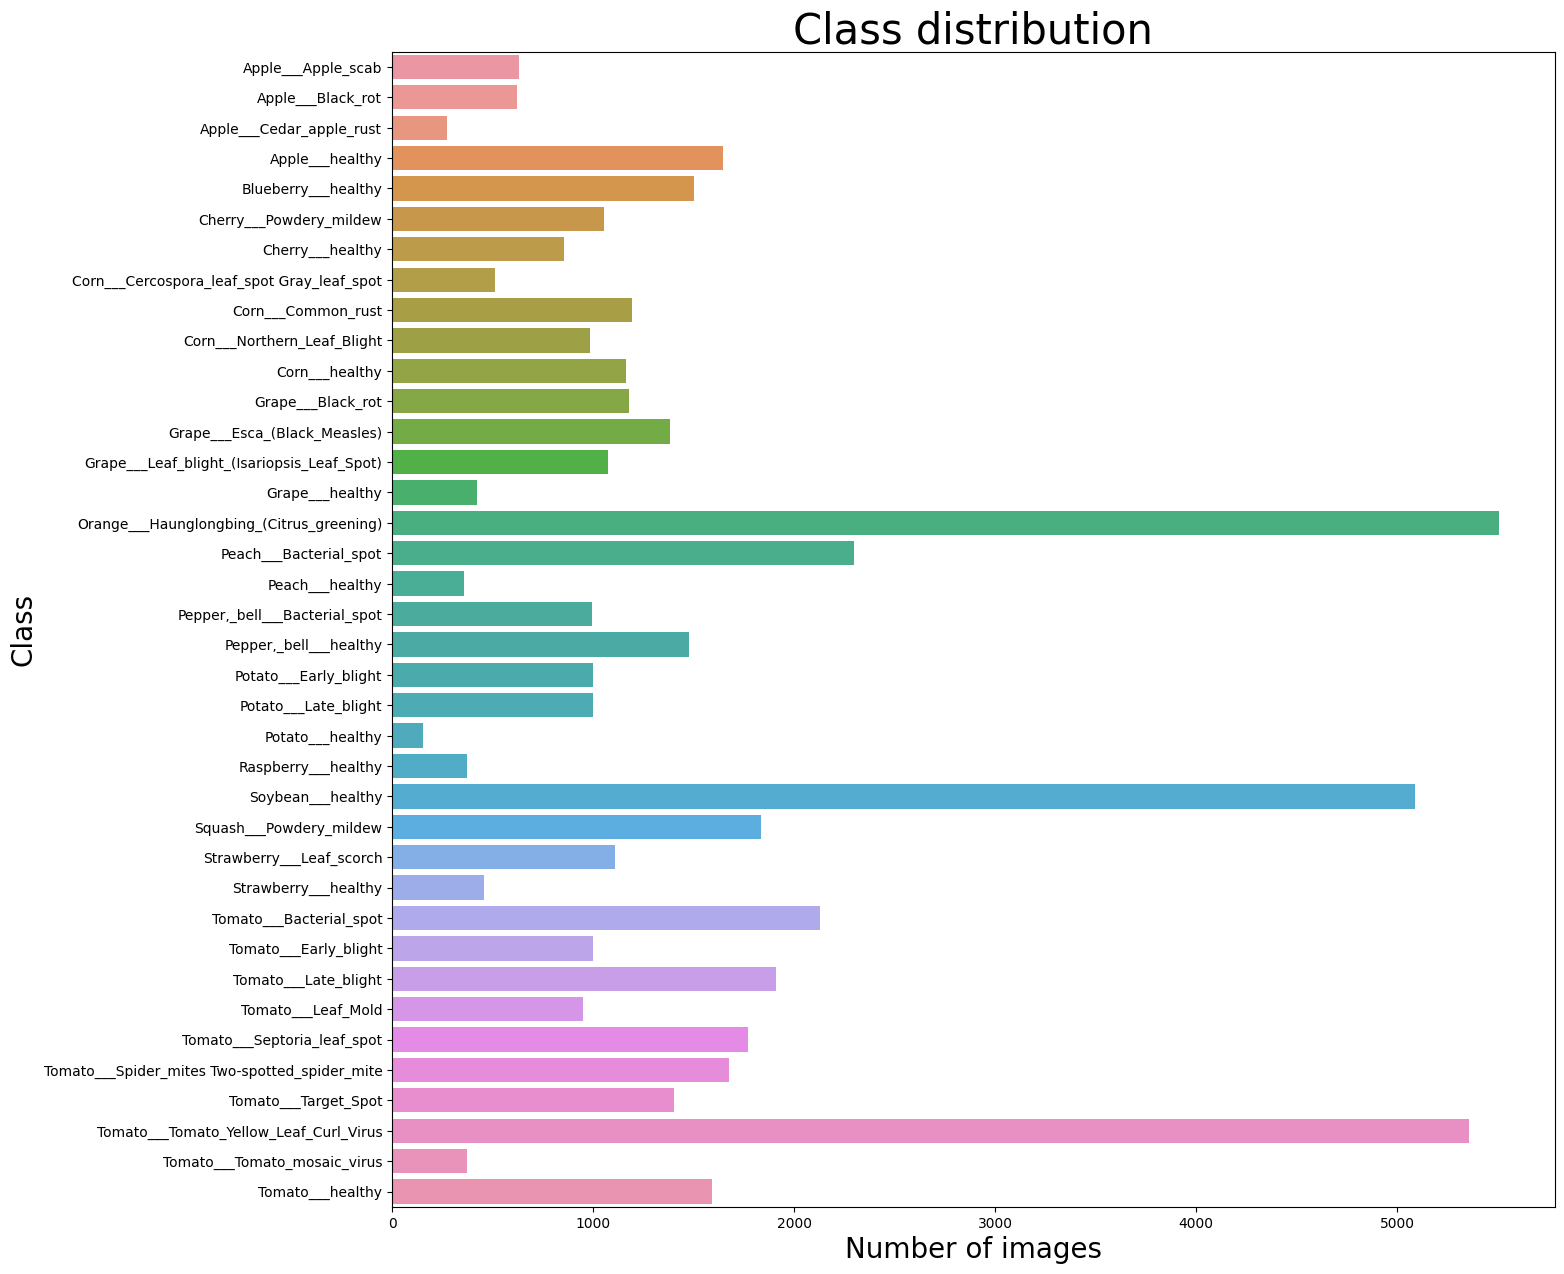

In [10]:
# Plot class distribution
plt.figure(figsize=(15,15))
plt.title('Class distribution',fontsize=30)
sns.barplot(y=diseaseDf['Class'],x=diseaseDf['Total_images'])
plt.xlabel('Number of images',fontsize=20)
plt.ylabel('Class',fontsize=20);

Show a random image for each class to better understand the data (pictures).

In [11]:
listPlants = list(plantDf.Plant)

# For every unique plant
for plant in listPlants:
  listDiseases = diseaseDf.Disease[diseaseDf['Plant']==plant].tolist()

  # Create subplot mesh with maximum of 4 columns (based on number of diseases)
  numDiseases = len(listDiseases)
  cols = min(4,numDiseases)
  rows = (numDiseases + cols - 1) // cols

  fig, ax = plt.subplots(nrows=rows,
                         ncols=cols,
                         figsize=(cols * 4,rows * 4),
                         squeeze=False)

  fig.suptitle(plant,fontsize=20)

  # For every disease the plant can have
  for i, disease in enumerate(listDiseases):
    row = i // cols
    col = i % cols

    # Plot one image, chosen randomly from the dataset
    numImages = diseaseDf.loc[(diseaseDf['Plant']==plant)&(diseaseDf['Disease']==disease),'Total_images'].values[0]
    randomImageIndex = random.randint(0,numImages - 1)

    imgPath = individualDf[(individualDf.Plant==plant)&(individualDf.Disease==disease)].iloc[randomImageIndex,3]
    img = plt.imread(imgPath)

    ax[row,col].axis('off')
    ax[row,col].set_title(disease)
    ax[row,col].imshow(img)

  # Remove any empty subplots in the last row
  for j in range(len(listDiseases),rows * cols):
      row = j // cols
      col = j % cols
      fig.delaxes(ax[row,col])

  plt.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# DATA PREPROCESSING

Split the dataset into training, validation and testing datasets. This is done by creating a new directories into which the images are split.

In [19]:
# Set paths to save training, validation, and testing data
baseDir = localPathToImages+'(Split)'
trainDir = os.path.join(baseDir,'Train')
validDir = os.path.join(baseDir,'Validation')
testDir = os.path.join(baseDir,'Test')

# Create directories if they don't exist
if not os.path.exists(baseDir):
  os.makedirs(baseDir)
  os.makedirs(trainDir)
  os.makedirs(validDir)
  os.makedirs(testDir)

  # Loop through subfolders (class labels)
  for label in os.listdir(localPathToImages):
    labelDir = os.path.join(localPathToImages,label)

    # List all image filenames in the current class label directory
    imageFilenames = os.listdir(labelDir)

    # Calculate the size for each subset
    totalSamples = len(imageFilenames)
    trainSize = int(trainValTestRatio[0] * totalSamples)
    valTestSize = totalSamples - trainSize
    valSize = int(valTestSize * (trainValTestRatio[1] / sum(trainValTestRatio[1:])))
    testSize = valTestSize - valSize

    # Split dataset into train, validation and test sets
    temp, train = train_test_split(imageFilenames,test_size=trainSize,random_state=randomState)
    valid, test = train_test_split(temp,test_size=testSize,random_state=randomState)

    # Create subdirectories for each class in the train, validation, and test directories
    trainLabelDir = os.path.join(trainDir,label)
    validLabelDir = os.path.join(validDir,label)
    testLabelDir = os.path.join(testDir,label)

    os.makedirs(trainLabelDir,exist_ok=True)
    os.makedirs(validLabelDir,exist_ok=True)
    os.makedirs(testLabelDir,exist_ok=True)

    # Move images to respective directories
    for filename in train:
      shutil.copy(os.path.join(labelDir,filename),os.path.join(trainLabelDir,filename))
    for filename in valid:
      shutil.copy(os.path.join(labelDir,filename),os.path.join(validLabelDir,filename))
    for filename in test:
      shutil.copy(os.path.join(labelDir,filename),os.path.join(testLabelDir,filename))

Because of the class inbalanced showed earlier, the classes needs to get 'balanced' somehow. So to 'balance' the classes, the class weights are calculated.

In [13]:
# Calculate the number of images for each class in the training dataset
imageCount = {}
for root, dirs, files in os.walk(trainDir):
  for dirName in dirs:
    folderPath = os.path.join(root, dirName)
    imageCount[dirName] = len([f for f in os.listdir(folderPath)])

# Calculate class weights
classWeights = {key: sum(imageCount.values()) / (len(imageCount) * value) for key, value in imageCount.items()}
classWeightsTensor = torch.Tensor(list(classWeights.values()))

# Total number of batches
wholeBatches = math.floor(sum(imageCount.values()) / batchSize)
totalBatches = wholeBatches - (wholeBatches % nProcs)


# NEURAL NETWORK AND PYTORCH DESIGN

Construct custom CNN model with pytorch.

In [6]:
class Model(nn.Module):
  def __init__(self,):
    super(Model,self).__init__()

    # Convolutional layer
    self.convolutionalLayer = nn.Sequential(

        # First block
        nn.Conv2d(in_channels=3,out_channels=128,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2),

        # Second block
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2),

        # Third block
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(kernel_size=2))

    # Fully connected layer
    self.fcLayer = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=(512 * 8 * 8),out_features=512),
        nn.ReLU(inplace = True),
        nn.Linear(in_features=512,out_features=38))

  def forward(self,x):
      x = self.convolutionalLayer(x)
      x = x.view(x.size(0),-1)
      x = self.fcLayer(x)
      return x

# TRAINING THE NETWORK

The main training loop that will run on each TPU core.

In [8]:
wrappedModel = xmp.MpModelWrapper(Model())
serialExe = xmp.MpSerialExecutor()
saveModel = os.path.join(savePath,'trainedModel.pth')
saveMetrics = os.path.join(savePath,'metrics.pth')

def trainTPU(rank,flags):
  torch.set_default_tensor_type('torch.FloatTensor')
  xm.set_rng_state(randomState)

  def loadDatasets():
    # Define data augmentation and transforms
    trainTransform = transforms.Compose([transforms.Resize(targetSize),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ColorJitter(brightness=brightness,contrast=contrast,saturation=saturation,hue=hue),
                                         transforms.RandomRotation(degrees=degrees),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=transformMean,std=transformStd)])

    transform = transforms.Compose([transforms.Resize(targetSize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=transformMean,std=transformStd)])

    # Load the datasets and apply transforms
    trainDataset = ImageFolder(root=trainDir,transform=trainTransform)
    validDataset = ImageFolder(root=validDir,transform=transform)

    return trainDataset,validDataset

  trainDataset,validDataset = serialExe.run(loadDatasets)

  # Create samplers
  trainSampler = torch.utils.data.distributed.DistributedSampler(trainDataset,num_replicas=xm.xrt_world_size(),rank=xm.get_ordinal(),shuffle=True)
  validSampler = torch.utils.data.distributed.DistributedSampler(validDataset,num_replicas=xm.xrt_world_size(),rank=xm.get_ordinal(),shuffle=False)

  # Create DataLoaders
  trainLoader = DataLoader(trainDataset,batch_size=batchSize,sampler=trainSampler,drop_last=True,num_workers=numWorkers)
  validLoader = DataLoader(validDataset,batch_size=batchSize,sampler=validSampler,drop_last=True,num_workers=numWorkers)

  # Training config
  device = xm.xla_device()
  model = wrappedModel.to(device)
  optimizer = optim.Adam(model.parameters(),lr=learningRate,weight_decay=weightDecay)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs,eta_min=etaMin)
  lossFn = nn.CrossEntropyLoss(weight=classWeightsTensor.to(device))

  # Training function
  def trainFun(loader):
    totalLossPerEpoch = 0.0
    correct = 0
    totalSamples = 0
    model.train()

    for x, (data,target) in enumerate(loader):
      # Train the model
      optimizer.zero_grad()
      output = model(data)
      loss = lossFn(output,target)
      loss.backward()
      xm.optimizer_step(optimizer)

      # Calculate metrics
      pred = output.max(1,keepdim=True)[1] # Determine the classe with highest value
      correct += pred.eq(target.view_as(pred)).sum().item() # Calculate the number of correct pred
      totalSamples += data.size()[0]
      totalLossPerEpoch += loss.item()

      if (x + 1) % displayAfterIter == 0:
        lossPerEpoch = totalLossPerEpoch / (x + 1)
        accuracy = 100 * (correct / totalSamples)

        aggregatedLoss = xm.mesh_reduce('aggregatedLoss',lossPerEpoch,lambda x: sum(x) / xm.xrt_world_size())
        aggregatedAccuracy = xm.mesh_reduce('aggregatedAccuracy',accuracy,lambda x: sum(x) / xm.xrt_world_size())
        xm.master_print(f'[xla:master]({(x + 1) * xm.xrt_world_size()}/{totalBatches})|loss={aggregatedLoss:.5f}|accuracy={aggregatedAccuracy:.2f}%|lr={optimizer.param_groups[0]["lr"]:.6f}|time={((time.time()-start) / 60):.1f}min')


    lossPerEpoch = totalLossPerEpoch / (x + 1) # Calculate the mean loss per epoch
    accuracy = 100 * (correct / totalSamples)

    aggregatedLoss = xm.mesh_reduce('aggregatedLoss2',lossPerEpoch,lambda x: sum(x) / xm.xrt_world_size())
    aggregatedAccuracy = xm.mesh_reduce('aggregatedAccuracy2',accuracy,lambda x: sum(x) / xm.xrt_world_size())
    xm.master_print(f'[xla:master]({(x + 1) * xm.xrt_world_size()}/{totalBatches})|loss={aggregatedLoss:.5f}|accuracy={aggregatedAccuracy:.2f}%|lr={optimizer.param_groups[0]["lr"]:.6f}|time={((time.time()-start) / 60):.1f}min')

    return aggregatedAccuracy,aggregatedLoss

  # Validation function
  def validFun(loader):
    totalLossPerEpoch = 0.0
    correct = 0
    totalSamples = 0
    model.eval()

    with torch.no_grad():
      for x,(data,target) in enumerate(loader):
        output = model(data)

        loss = lossFn(output,target)
        totalLossPerEpoch += loss.item()

        pred = output.max(1,keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        totalSamples += data.size()[0]

      lossPerEpoch = totalLossPerEpoch / (x + 1)
      accuracy = 100 * (correct / totalSamples)

      aggregatedLoss = xm.mesh_reduce('aggregatedLoss3',lossPerEpoch,lambda x: sum(x) / xm.xrt_world_size())
      aggregatedAccuracy = xm.mesh_reduce('aggregatedAccuracy3',accuracy,lambda x: sum(x) / xm.xrt_world_size())
      xm.master_print(f'[xla:master]|loss={aggregatedLoss:.5f}|accuracy={aggregatedAccuracy:.2f}%|time={((time.time()-start) / 60):.1f}min')

      return aggregatedAccuracy,aggregatedLoss

  # Initialise lists
  listAccValid = []
  listAccTrain = []
  listLossValid = []
  listLossTrain = []
  start = time.time()

  for epoch in range(1, epochs + 1):
    xm.master_print(f'------------------- Epoch {epoch} ---------------------')

    # Training
    paraLoader = pl.ParallelLoader(trainLoader, [device])
    xm.master_print('*** TRAINING ***')
    accuracyTrain, lossTrain = trainFun(paraLoader.per_device_loader(device))
    xm.master_print(f'Finished training epoch {epoch}')

    # Update learning rate
    scheduler.step()

    # Validation
    paraLoader = pl.ParallelLoader(validLoader, [device])
    xm.master_print('*** VALIDATION ***')
    accuracyValid,lossValid = validFun(paraLoader.per_device_loader(device))
    xm.master_print(f'Finished validating epoch {epoch}')
    xm.master_print(f'############### EPOCH {epoch} COMPLETED ###############')

    listAccValid.append(accuracyValid)
    listAccTrain.append(accuracyTrain)
    listLossValid.append(lossValid)
    listLossTrain.append(lossTrain)

  # Combine lists into a single dictionary
  metrics = {'trainLoss':listLossTrain,'trainAccuracy':listAccTrain,'validLoss':listLossValid,'validAccuracy':listAccValid}

  xm.master_print(f'Saving...')
  xm.save(metrics,saveMetrics)
  xm.save(model.state_dict(),saveModel)
  xm.master_print('Files saved successfully')
  xm.master_print('FINISHED')

Start the training on multiple cores.

In [16]:
startTime = time.time()
xmp.spawn(trainTPU,args=({},),nprocs=nProcs,start_method='fork')
endTime = time.time()
print(f'Total run time = {(endTime-startTime) / 60:.1f} min')

------------------- Epoch 1 ---------------------
*** TRAINING ***
[xla:master](40/296)|loss=12.75000|accuracy=11.29%|lr=0.001000|time=0.5min
[xla:master](80/296)|loss=8.11992|accuracy=16.90%|lr=0.001000|time=0.5min
[xla:master](120/296)|loss=6.20013|accuracy=21.87%|lr=0.001000|time=0.5min
[xla:master](160/296)|loss=5.15532|accuracy=25.52%|lr=0.001000|time=0.5min
[xla:master](200/296)|loss=4.48719|accuracy=28.48%|lr=0.001000|time=0.6min
[xla:master](240/296)|loss=4.02946|accuracy=30.64%|lr=0.001000|time=0.6min
[xla:master](280/296)|loss=3.67877|accuracy=32.61%|lr=0.001000|time=0.6min
[xla:master](296/296)|loss=3.56234|accuracy=33.33%|lr=0.001000|time=0.6min
Finished training epoch 1
*** VALIDATION ***
[xla:master]|loss=1.41103|accuracy=49.62%|time=0.9min
Finished validating epoch 1
############### EPOCH 1 COMPLETED ###############
------------------- Epoch 2 ---------------------
*** TRAINING ***
[xla:master](40/296)|loss=1.42480|accuracy=47.73%|lr=0.001000|time=0.9min
[xla:master](80/

# LOADING MODEL AND EVALUATION

In [9]:
# Load the saved model and metrics.
model = Model()
device = xm.xla_device()
model.load_state_dict(torch.load(saveModel))
model.to(device)
metrics = torch.load(saveMetrics)

In [10]:
# Function to plot accuracy and loss curves
def plotAccLoss(listAccValid,listAccTrain,listLossValid,listLossTrain):
  print(f'Accuracy for train dataset:{listAccTrain[-1]:.2f}%')
  print(f'Accuracy for valid dataset:{listAccValid[-1]:.2f}%')
  print(f'Last 5 loss values for train dataset:{listLossTrain[-5:]}')
  print(f'Last 5 loss values for valid dataset:{listLossValid[-5:]}')
  print('\n')

  # Accuracy curves
  plt.figure(figsize=(21,7))
  plt.subplot(131)
  plt.plot(listAccTrain,"royalblue",linewidth=2)
  plt.plot(listAccValid,"tomato",linewidth=2)
  plt.title('Model accuracy per epoch',fontsize=16)
  plt.ylabel('accuracy',fontsize=14)
  plt.xlabel('epoch',fontsize=14)
  plt.legend(['train', 'valid'], loc='right',fontsize=14)

  # Loss curves
  plt.subplot(132)
  plt.plot(listLossTrain,"royalblue",linewidth=2)
  plt.plot(listLossValid,"tomato",linewidth=2)
  plt.title('Model loss per epoch',fontsize=16)
  plt.ylabel('loss',fontsize=14)
  plt.xlabel('epoch',fontsize=14)
  plt.legend(['train', 'valid'], loc='right',fontsize=14)

  # Log-scaled loss curve
  plt.subplot(133)
  plt.plot(listLossTrain,"royalblue",linewidth=2)
  plt.plot(listLossValid,"tomato",linewidth=2)
  plt.title('Model loss per epoch (logarithmic scale)',fontsize=16)
  plt.ylabel('loss',fontsize=14)
  plt.xlabel('epoch',fontsize=14)
  plt.yscale('log')
  plt.legend(['train', 'valid'], loc='right',fontsize=14)
  plt.show()

In [11]:
# Function to plot learning rate over epochs
def plotLR(initialLR,etaMin,numEpochs):
  # Dummy optimizer for learning rate scheduling
  optimizer = optim.SGD([torch.nn.Parameter(torch.randn(10, 10))],lr=initialLR)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=numEpochs,eta_min=etaMin)

  lrValues = []
  for epoch in range(numEpochs):
    lrValues.append(optimizer.param_groups[0]['lr'])  # Record the current learning rate
    optimizer.step()  # Prevents warning
    scheduler.step()  # Step the scheduler

  # Plotting the learning rate
  plt.plot(range(1,numEpochs+1),lrValues)
  plt.xlabel('Epoch')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate Schedule')
  plt.grid(True)
  plt.show()

Accuracy for train dataset:99.80%
Accuracy for valid dataset:99.15%
Last 5 loss values for train dataset:[0.007570730673300254, 0.007416596283783784, 0.0076905843373891464, 0.007627770707413957, 0.007607743546769426]
Last 5 loss values for valid dataset:[0.022225584302629744, 0.02249697276524135, 0.022218704223632812, 0.022201061248779293, 0.022136415754045763]




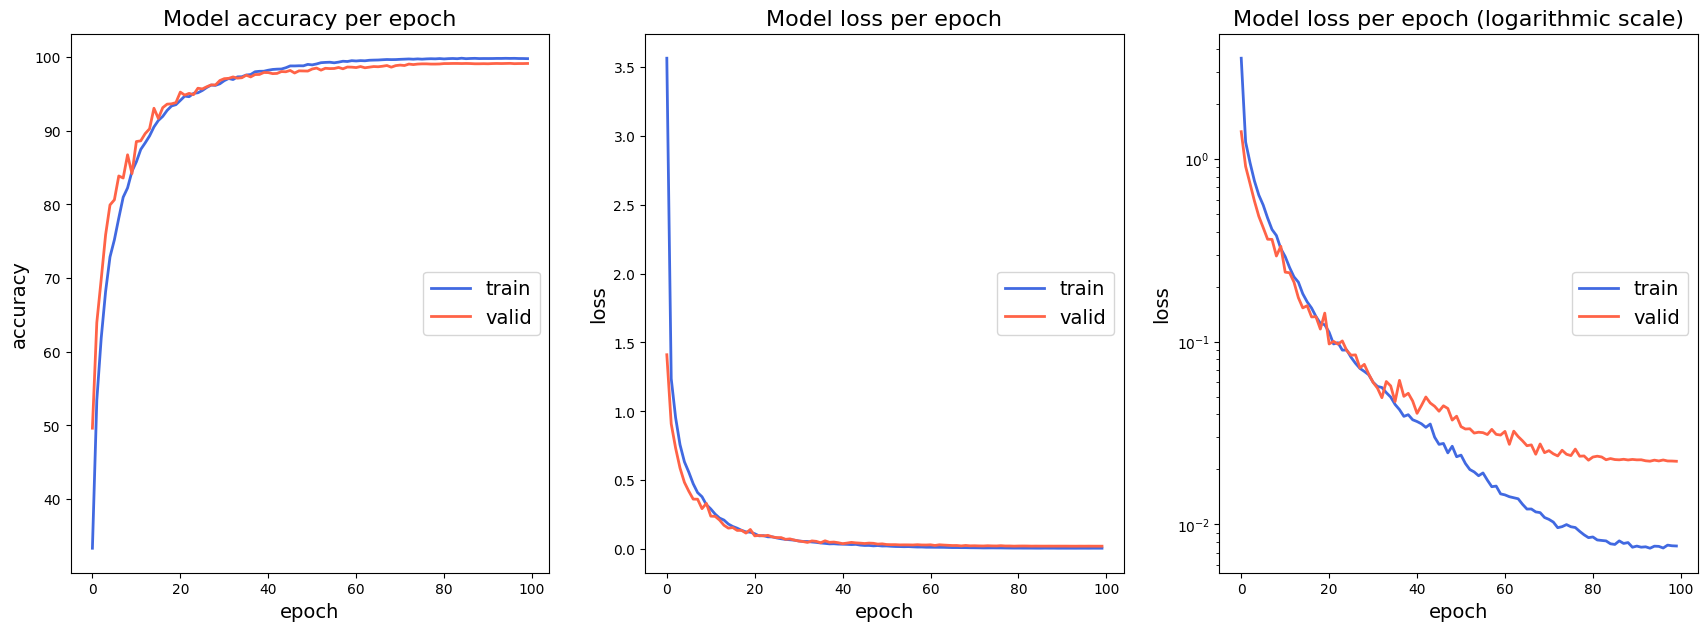

In [12]:
# Plot accuracy and loss curves
plotAccLoss(metrics['validAccuracy'],metrics['trainAccuracy'],metrics['validLoss'],metrics['trainLoss'])

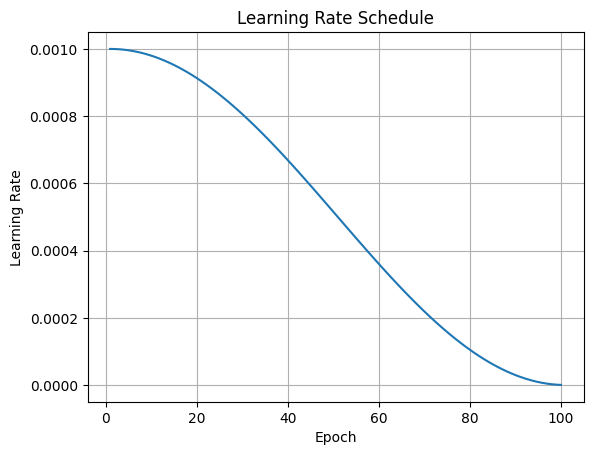

In [13]:
# Plot learning rate schedule
plotLR(learningRate,etaMin,epochs)

In [14]:
# Model's structure
cnn = Model()
summary(cnn,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
              ReLU-2          [-1, 128, 64, 64]               0
       BatchNorm2d-3          [-1, 128, 64, 64]             256
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 256, 32, 32]         295,168
              ReLU-6          [-1, 256, 32, 32]               0
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         MaxPool2d-8          [-1, 256, 16, 16]               0
            Conv2d-9          [-1, 512, 16, 16]       1,180,160
             ReLU-10          [-1, 512, 16, 16]               0
      BatchNorm2d-11          [-1, 512, 16, 16]           1,024
        MaxPool2d-12            [-1, 512, 8, 8]               0
          Dropout-13                [-1, 32768]               0
           Linear-14                  [

# TEST DATASET PREDICTIONS AND EVALUATION

In [20]:
# Construct loader for the testing dataset
transform = transforms.Compose([transforms.Resize(targetSize),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=transformMean,std=transformStd)])

testDataset = ImageFolder(root=testDir,transform=transform)
testLoader = DataLoader(testDataset,batch_size=batchSize,shuffle=False,num_workers=numWorkers)

In [21]:
@torch.no_grad()
def getAllPreds(model, loader, device):
  allPreds = torch.tensor([]).to(device)
  model.eval()
  for batch in loader:
    images, _ = batch

    preds = model(images.to(device))
    allPreds = torch.cat((allPreds,preds),dim=0)

  return allPreds

# Predict labels
testPreds = getAllPreds(model,testLoader,device)

# Get predicted labels
predLabels = testPreds.argmax(dim=1)

# Get actual labels
actualLabels = torch.tensor(testDataset.targets).to(device)

# Calculate the number of correctly predicted images
predsCorrect = testPreds.argmax(dim=1).eq(actualLabels).sum().item()

print(f'total correct: {predsCorrect} / {len(testDataset)}')
print(f'accuracy: {100 * (predsCorrect / len(testDataset)):.2f}%')

total correct: 8089 / 8163
accuracy: 99.09%


CONFUSION MATRIX

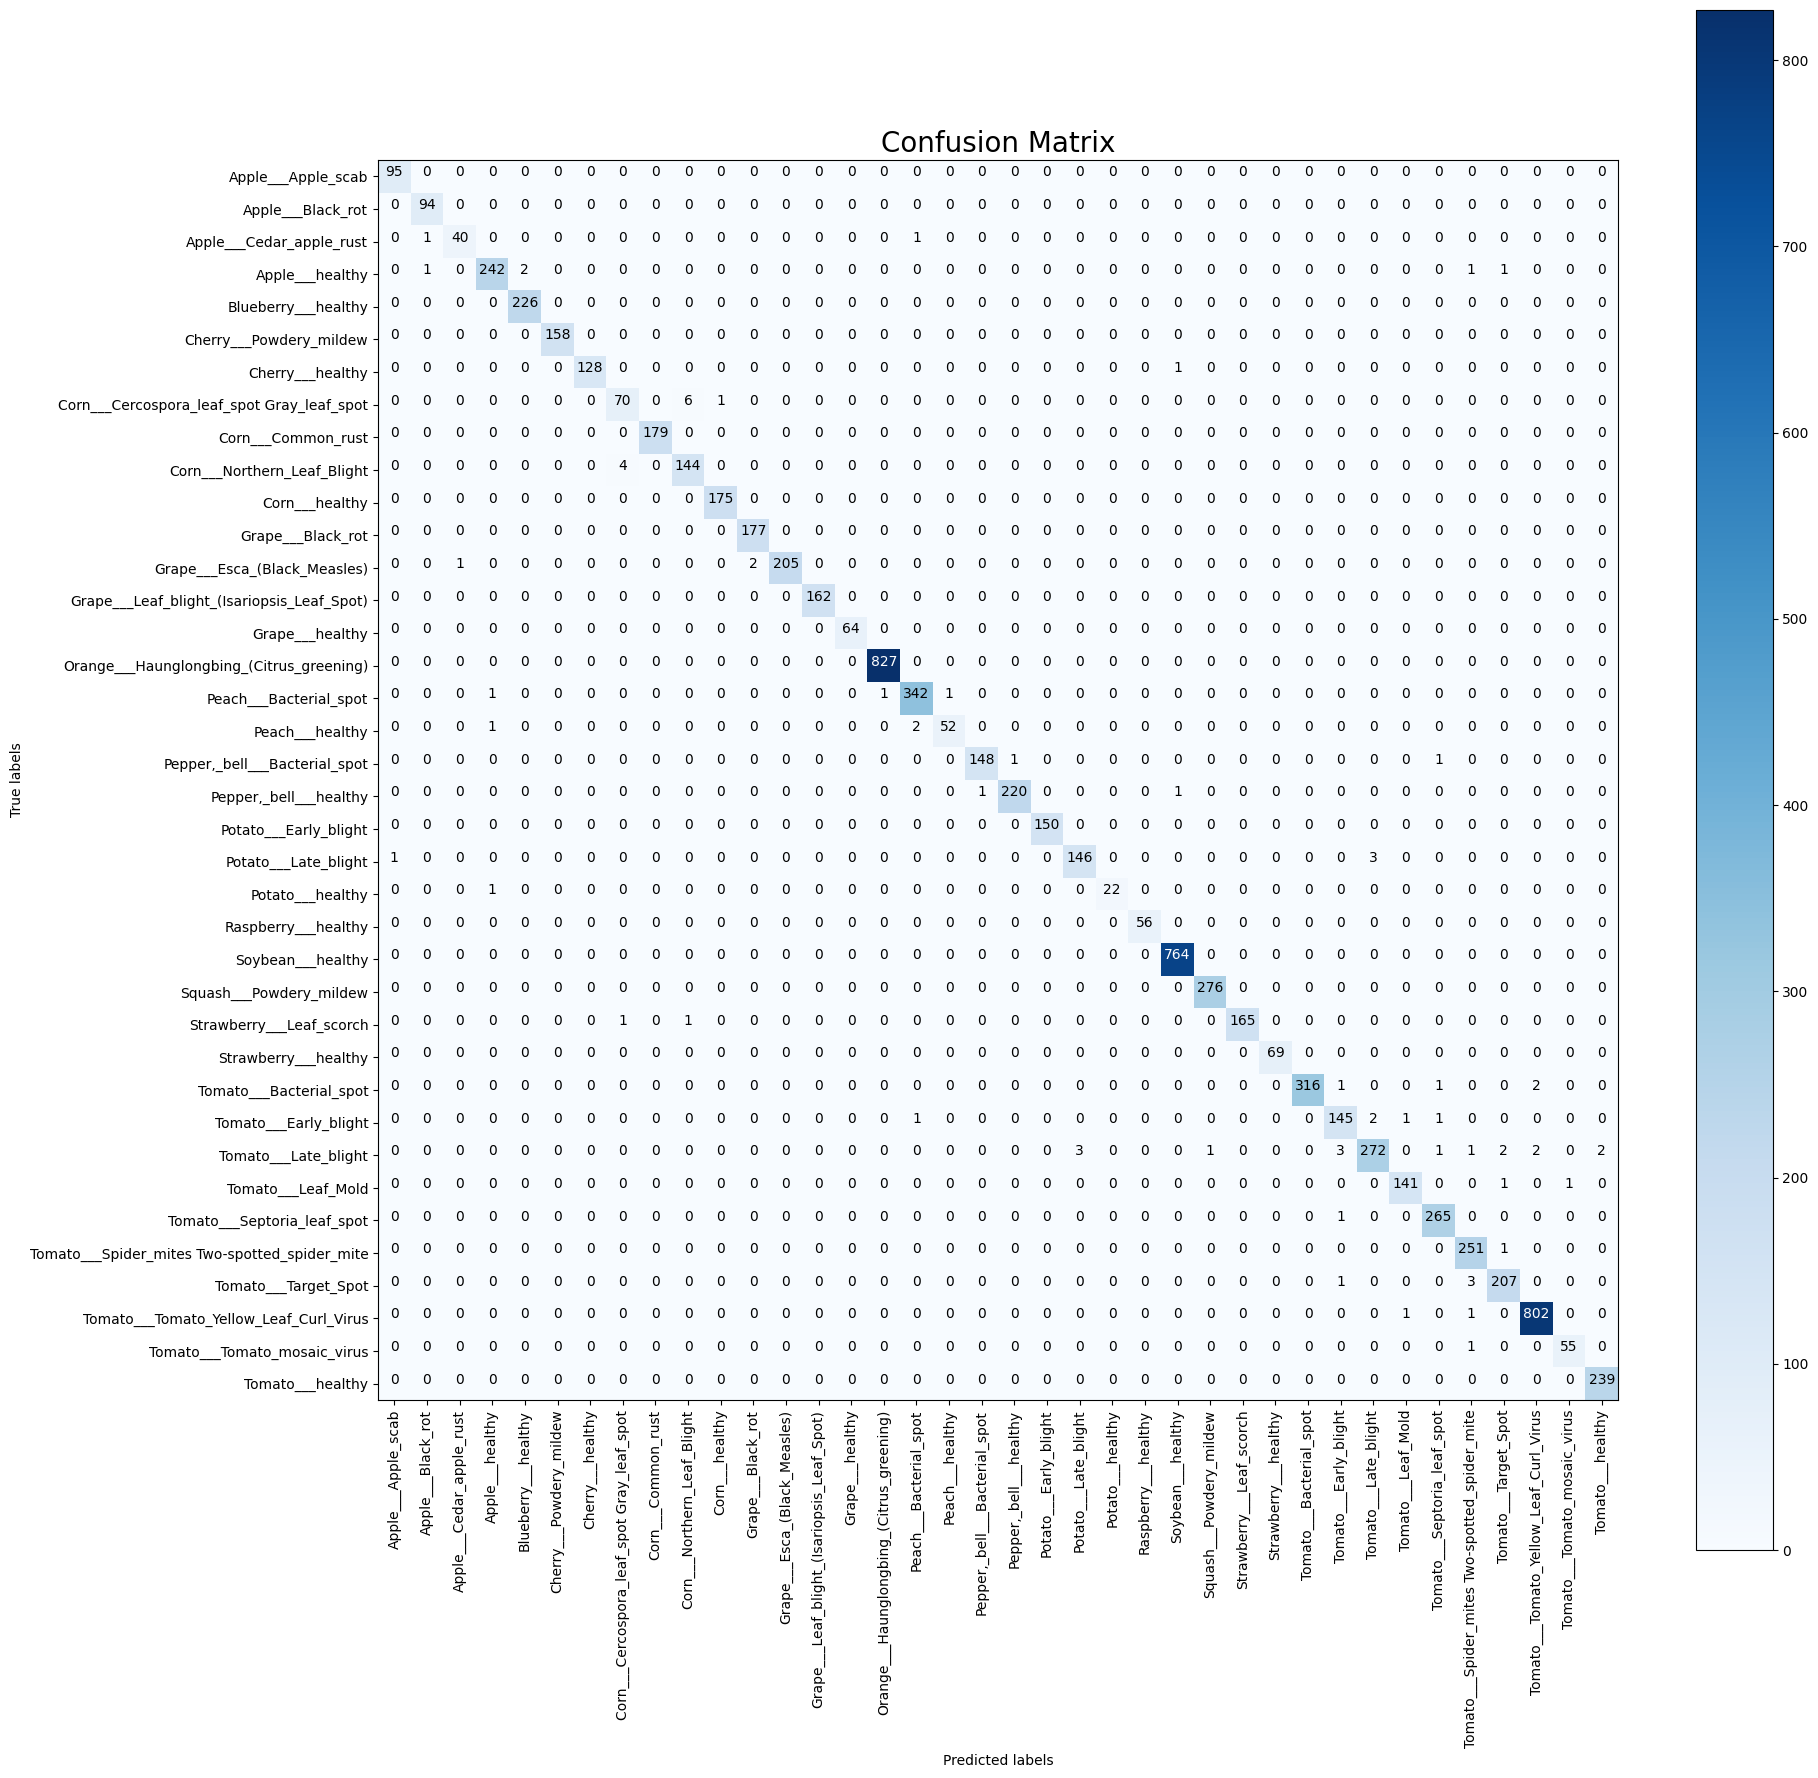

In [39]:
# Create confusion matrix
cnfMatrix = confusion_matrix(actualLabels.cpu(),predLabels.cpu())
classes = testDataset.classes

# Calculate accuracy for each class
class_accuracies = cnfMatrix.diagonal() / cnfMatrix.sum(axis=1) * 100

# Print class accuracies
data = {'Class Name': classes, 'Accuracy': [f'{accuracy:.2f}' for accuracy in class_accuracies]}
eachClassDf = pd.DataFrame(data)

plt.figure(figsize=(20,20))
plt.imshow(cnfMatrix,interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix",fontsize=20)
plt.colorbar()

# Setup the ticks on x and y axis
tickMarks = np.arange(len(classes))
plt.xticks(tickMarks,classes,rotation='vertical')
plt.yticks(tickMarks,classes)

# Adjust the color and position of numbers
thresh = cnfMatrix.max() / 2.0
for i, j in itertools.product(range(cnfMatrix.shape[0]),range(cnfMatrix.shape[1])):

  plt.text(j,i,cnfMatrix[i,j],
           horizontalalignment='center',
           color='white' if cnfMatrix[i, j] > thresh else 'black')

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

In [40]:
display(eachClassDf)

,Class Name,Accuracy
0,Apple___Apple_scab,100.00
1,Apple___Black_rot,100.00
2,Apple___Cedar_apple_rust,95.24
3,Apple___healthy,97.98
4,Blueberry___healthy,100.00
5,Cherry___Powdery_mildew,100.00
6,Cherry___healthy,99.22
7,Corn___Cercospora_leaf_spot Gray_leaf_spot,90.91
8,Corn___Common_rust,100.00
9,Corn___Northern_Leaf_Blight,97.30
